# Самостоятельная работа OD-1
1. Оценить количество ботов, которые заходят на наш сайт, и их долю от всего трафика.
2. Определить, с каких источников и в какое время суток чаще всего заходят роботы.

* Если доля роботов будет ощутимой, проверить на всплески и отказы.

*Примечание. Роботами могут быть пауки поисковых систем, которые индексируют контент блога, или же различные парсеры и агрегаторы контента. «Яндекс.Метрика» позволяет находить этих роботов и показывает их в отдельном параметрe ym:s:isRobot, а также считает их долю в специальной метрике ym:s:robotPercentage.*

In [1]:
import json 
import requests
import pandas as pd
from pprint import pprint

In [2]:
token = 'AgAAAAAMQ6eyAAbv031LvkIBNEculQ1Ib2MLkts'
headers = {'Authorization': 'OAuth ' + token}

In [3]:
params = {
    'metrics': 'ym:s:visits,ym:s:robotPercentage',
    'dimensions': 'ym:s:lastsignTrafficSource,ym:s:browserHour',
    'date1': '2020-09-01',
    'date2': '2020-09-30',
    'limit': 100000,
    'accuracy':'full',
    'ids': 30177909,
    'attribution':'first'
}
 
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
print (response.status_code) # проверяем корректность подключения

200


In [4]:
metrika_data = response.json()

#print(metrika_data.keys())  # смотрим доступные ключи 
#metrika_data['total_rows']  # убедились, что лимит можно было не выставлять :)

metrika_df = pd.DataFrame(metrika_data['data'])

#display(metrika_df.head(15)) # смотрим на корявую таблицу

In [5]:
def getMetrikaDataInListOfDicts(metrika_data):  # функция, превращающая наш словарь в человеческий вид
    list_of_dicts = []
    dimensions_list = metrika_data['query']['dimensions']
    metrics_list = metrika_data['query']['metrics']
    for data_item in metrika_data['data']:
        d = {}
        for i,dimension in enumerate(data_item['dimensions']):
            d[dimensions_list[i]] = dimension['name']
        for i,metric in enumerate(data_item['metrics']):
            d[metrics_list[i]] = metric
        list_of_dicts.append(d)
    return list_of_dicts

In [6]:
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
metrika_df = pd.DataFrame(metrika_list_of_dicts)
metrika_df.columns = ['Source','Hour','Visits','Bots_rate']  # переименуем колонки
metrika_df.isnull().sum()  # проверяем таблицу на пропуски

Source       0
Hour         0
Visits       0
Bots_rate    0
dtype: int64

In [7]:
metrika_df['Bots_rate'] = metrika_df['Bots_rate']/100        # приведем долю ботов в вещественное число
metrika_df['Bots'] = metrika_df['Bots_rate']*metrika_df['Visits'] # считаем кол-во ботов
metrika_df['Bots'] = metrika_df['Bots'].astype(int)          # приводим к целому числу
metrika_df['Visits'] = metrika_df['Visits'].astype(int)
display(metrika_df.head(10))

,Source,Hour,Visits,Bots_rate,Bots
0,Search engine traffic,16:00,250,0.220000,55
1,Search engine traffic,15:00,247,0.259109,63
2,Search engine traffic,12:00,234,0.243590,57
3,Search engine traffic,11:00,232,0.262931,61
4,Search engine traffic,13:00,228,0.263158,59
5,Search engine traffic,14:00,226,0.287611,65
6,Search engine traffic,17:00,216,0.250000,54
7,Search engine traffic,21:00,180,0.172222,30
8,Search engine traffic,10:00,176,0.181818,31
9,Search engine traffic,19:00,172,0.250000,43


In [8]:
print(f"Всего ботов за сентябрь: {metrika_df['Bots'].sum()}")
print(f"Всего визитов за сентябрь: {metrika_df['Visits'].sum()}")
print(f"Доля ботов за сентябрь: {metrika_df['Bots'].sum()/metrika_df['Visits'].sum():.2%}")

Всего ботов за сентябрь: 935
Всего визитов за сентябрь: 4315
Доля ботов за сентябрь: 21.67%


In [9]:
print('Доля ботов по источникам')
metrika_df.groupby('Source').Bots_rate.mean()
metrika_df['People'] = metrika_df['Visits'] - metrika_df['Bots']
metrika_df.pivot_table(index = 'Source', values = ['People','Bots','Bots_rate'],
                      aggfunc = {
                          'People':sum,
                          'Bots':sum,
                          'Bots_rate':'mean'
                      }).reindex(['People','Bots','Bots_rate'],axis = 1).sort_values(by = 'People', ascending = False)

Доля ботов по источникам


,People,Bots,Bots_rate
Source,,,
Search engine traffic,2608,726,0.191654
Direct traffic,587,170,0.236662
Link traffic,99,27,0.261329
Social network traffic,72,8,0.108117
Internal traffic,7,3,0.250000
Cached page traffic,5,1,0.100000
Recommendation system traffic,2,0,0.000000


# Вот и ответ на наш первый вопрос.
935 визитов из 4315 (21.67%) сделаны роботами. Основной трафик роботов из 4-х источников:
- Direct traffic
- Internal traffic
- Link traffic
- Search engine traffic  
  
### Теперь проверим из каких источников и в какое время чаще заходят роботы

In [10]:
print('Количество ботов по разным источникам и времени дня')
metrika_df.pivot_table(index = 'Hour', columns = 'Source', values = 'Bots', aggfunc = 'sum', margins = True).fillna('')

Количество ботов по разным источникам и времени дня


Source,Cached page traffic,Direct traffic,Internal traffic,Link traffic,Recommendation system traffic,Search engine traffic,Social network traffic,All
Hour,,,,,,,,
00:00,,3.0,,0,,19.0,,22
01:00,1,5.0,,0,,9.0,0,15
02:00,,0.0,0,0,,6.0,1,7
03:00,,2.0,,0,,2.0,,4
04:00,,3.0,,,,3.0,0,6
05:00,,1.0,,,,0.0,0,1
06:00,,1.0,,1,,0.0,0,2
07:00,,4.0,,2,,3.0,0,9
08:00,,3.0,0,1,0,21.0,1,26


Что ж, не стоит беспокоиться за Link traffic (27 ботов) и Internal traffic (3 бота). За месяц это достаточно мало.
Куда менее приятная ситуация с Search engine traffic (726 ботов) и Direct traffic (170).

На сводной таблице видны все данные, однако, по ним не очень удобно изучать пиковую активность. Взглянем на данные несколько иначе

In [11]:
print('Основной поток ботов в группировке по источнику и времени одновременно')
metrika_df.groupby(['Source','Hour']).sum().Bots.sort_values(ascending = False).head(10)

Основной поток ботов в группировке по источнику и времени одновременно


Source                 Hour 
Search engine traffic  14:00    65
                       15:00    63
                       11:00    61
                       13:00    59
                       12:00    57
                       16:00    55
                       17:00    54
                       19:00    43
                       20:00    34
                       18:00    33
Name: Bots, dtype: int32

Распределение активности ботов по времени
Hour
14:00    79
13:00    75
12:00    73
11:00    72
15:00    71
16:00    67
17:00    64
19:00    50
10:00    47
20:00    45
Name: Bots, dtype: int32



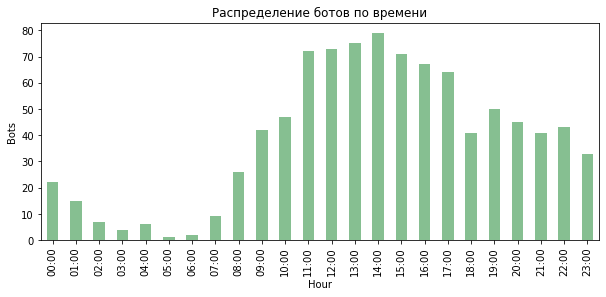

In [12]:
print('Распределение активности ботов по времени')
metrika_df1 = metrika_df.groupby('Hour').sum().Bots
print(metrika_df1.sort_values(ascending = False).head(10))
metrika_df1.plot(kind = 'bar', grid = False, ylabel = 'Bots', title = 'Распределение ботов по времени', color = '#86bf91', figsize = (10,4))
print('')

In [13]:
print('Распределение активности ботов по источникам')
metrika_df.groupby('Source').sum().Bots.sort_values(ascending = False)

Распределение активности ботов по источникам


Source
Search engine traffic            726
Direct traffic                   170
Link traffic                      27
Social network traffic             8
Internal traffic                   3
Cached page traffic                1
Recommendation system traffic      0
Name: Bots, dtype: int32

# Теперь у нас есть ответ на второй вопрос
Основная активность роботов приходится на эти источники:  
Search engine traffic - 726  
Direct traffic - 170  
  
Пиковая активность в середине рабочего дня (11:00 - 17:00)

## Разбираемся с ботами дальше

In [14]:
params = {
    'metrics': 'ym:s:visits,ym:s:avgVisitDurationSeconds,ym:s:bounceRate',
    'dimensions': 'ym:s:lastsignTrafficSource,ym:s:isRobot',
    'date1': '2020-09-01',
    'date2': '2020-09-30',
    'limit': 100000,
    'accuracy':'full',
    'ids': 30177909,
    'attribution':'first'
}
 
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
metrika_data = response.json()
metrika_df = pd.DataFrame(metrika_data['data'])

In [15]:
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
metrika_df = pd.DataFrame(metrika_list_of_dicts)
metrika_df.columns = ['Source','Status','Visits','Avg_duration','Bounce_rate']
metrika_df

,Source,Status,Visits,Avg_duration,Bounce_rate
0,Search engine traffic,People,2595.0,93.926012,12.678227
1,Search engine traffic,Robots,739.0,83.481732,12.313938
2,Direct traffic,People,580.0,92.317241,12.758621
3,Direct traffic,Robots,177.0,103.949153,23.728814
4,Link traffic,People,95.0,30.642105,12.631579
5,Social network traffic,People,69.0,84.246377,15.942029
6,Link traffic,Robots,31.0,40.709677,12.903226
7,Social network traffic,Robots,11.0,67.272727,9.090909
8,Internal traffic,People,7.0,30.000000,14.285714
9,Cached page traffic,People,5.0,10.200000,20.000000


При беглом анализе похоже, что роботы проводят на сайте достаточно много времени, а процент отказов сравним с людьми. Только боты через Direct traffic дают заметно больший процент отказов. Не похоже на скликивание, скорее всего это поисковые роботы, грабберы и агрегаторы.

https://vc.ru/seo/123347-zashchishchaem-svoy-sayt-ot-negativnoy-nakrutki-i-sklikivaniya-kontekstnoy-reklamy
Интересная статья о том, как убивают сайты негативной накруткой.

In [16]:
params = {
    'metrics': 'ym:s:visits,ym:s:avgVisitDurationSeconds,ym:s:bounceRate',
    'dimensions': 'ym:s:month,ym:s:isRobot',
    'date1': '2020-01-01',
    'date2': '2020-12-31',
    'limit': 100000,
    'accuracy':'full',
    'ids': 30177909,
    'attribution':'first'
}
 
response = requests.get('https://api-metrika.yandex.net/stat/v1/data', params=params, headers=headers)
metrika_data = response.json()
metrika_df = pd.DataFrame(metrika_data['data'])

,Month,Status,Visits,Avg_duration,Bounce_rate
9,1,People,2664.0,84.621622,12.012012
23,1,Robots,425.0,71.917647,19.529412
4,10,People,3783.0,89.098335,13.957177
15,10,Robots,739.0,76.215156,17.456022
3,11,People,3858.0,86.865993,13.919129
14,11,Robots,769.0,82.715215,13.784135
8,12,People,2743.0,82.216916,14.363835
19,12,Robots,632.0,82.960443,13.291139
11,2,People,2547.0,86.658029,12.995681
21,2,Robots,536.0,81.559701,15.671642


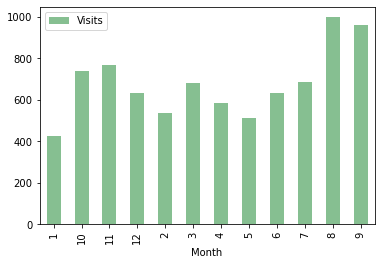

In [17]:
metrika_list_of_dicts = getMetrikaDataInListOfDicts(metrika_data)
metrika_df = pd.DataFrame(metrika_list_of_dicts)
metrika_df.columns = ['Month','Status','Visits','Avg_duration','Bounce_rate']
display(metrika_df.sort_values(['Month','Status']))
metrika_df[metrika_df['Status'] == 'Robots'].sort_values('Month').plot(x = 'Month', y = 'Visits', kind = 'bar',  color = '#86bf91')
print('')

Итак, мы проверили активность ботов на протяжении всего 2020 года. Наблюдался небольшой подъем в августе и сентябре, но заметных всплесков не было.

# Заключение
В сентябре 2020 на нашем сайте было 935 визитов роботов, что составило немногим менее 22% от общего числа (4315 визитов всего).  
  
Пик активности роботов приходится на середину рабочего дня, ночью активность затухает.  
Почти все роботы совершают переходы через поисковые системы и осуществляя прямые переходы (search engine и direct трафики).  
  
Для спокойствия я сравнил среднюю продолжительность визитов и долю отказов у роботов и людей, а так же проверил, не было ли всплесков активности роботов за 2020 год. Никаких аномалий не выявлено; нет оснований полагать, что кто-то пытается скликать наш сайт. Вероятно, это поисковые роботы и агрегаторы.